<a href="https://colab.research.google.com/github/aseelalzaben03/Task-3/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
dataset_path = '/content/drive/My Drive/data'
print("Files and folders in the dataset path:")
print(os.listdir(dataset_path))


Files and folders in the dataset path:
['images', 'labels']


In [4]:
images_path='/content/drive/My Drive/data/images'
labels_path='/content/drive/My Drive/data/labels'
print("Images:", os.listdir(images_path))
print("labels data:", os.listdir(labels_path))

Images: ['194.tif', '184.tif', '80.tif', '36.tif', '172.tif', '245.tif', '24.tif', '66.tif', '1.tif', '193.tif', '70.tif', '136.tif', '271.tif', '0.tif', '3.tif', '25.tif', '35.tif', '283.tif', '77.tif', '63.tif', '209.tif', '94.tif', '257.tif', '57.tif', '277.tif', '227.tif', '282.tif', '156.tif', '177.tif', '280.tif', '178.tif', '27.tif', '204.tif', '300.tif', '117.tif', '67.tif', '50.tif', '214.tif', '73.tif', '61.tif', '252.tif', '78.tif', '215.tif', '9.tif', '132.tif', '100.tif', '297.tif', '133.tif', '122.tif', '37.tif', '10.tif', '40.tif', '223.tif', '152.tif', '241.tif', '181.tif', '115.tif', '188.tif', '89.tif', '270.tif', '46.tif', '42.tif', '84.tif', '203.tif', '265.tif', '107.tif', '38.tif', '180.tif', '22.tif', '161.tif', '196.tif', '56.tif', '140.tif', '105.tif', '264.tif', '267.tif', '195.tif', '289.tif', '304.tif', '232.tif', '255.tif', '278.tif', '219.tif', '52.tif', '269.tif', '160.tif', '6.tif', '79.tif', '127.tif', '112.tif', '18.tif', '58.tif', '234.tif', '86.tif',

## Preprocessing AND Visualization

In [5]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.7 MB/s eta 0:00:00


In [6]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [7]:
def load_multispectral_image(image_path):
    """Loads a multispectral image while maintaining its original shape and resolution."""
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands
        profile = src.profile  # Preserve metadata
    return image, profile

def normalize_image(image):
    """Applies Min-Max normalization across all bands."""
    normalized_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):  # Iterate over bands
        band = image[i]
        min_val, max_val = band.min(), band.max()
        normalized_image[i] = (band - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero
    return normalized_image


In [8]:
def visualize_bands(image, bands=(0, 1, 2), title="RGB Composite"):
    """Visualizes selected bands as an RGB composite."""
    rgb_image = np.stack([image[b] for b in bands], axis=-1)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [9]:
import cv2

def denoise_image(image):
    """Apply Gaussian blur to remove noise while preserving edges."""
    denoised_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):  # Apply per band
        denoised_image[i] = cv2.GaussianBlur(image[i], (5, 5), 0)
    return denoised_image


In [10]:
def remove_clouds(image, threshold=0.8):
    """Mask out clouds based on NIR band intensity."""
    nir_band = image[3]  # Assuming NIR is the 4th band
    mask = nir_band < threshold  # Create a mask (low NIR = cloud)
    return image * mask  # Apply mask


In [11]:
from skimage.exposure import match_histograms

def match_histogram(source, reference):
    """Match histogram of source image to reference image."""
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):
        matched[i] = match_histograms(source[i], reference[i], multichannel=False)
    return matched


In [12]:
from skimage.transform import resize

def resample_image(image, target_shape):
    """Resizes image to match target shape."""
    resampled = np.zeros((image.shape[0], target_shape[0], target_shape[1]), dtype=np.float32)
    for i in range(image.shape[0]):
        resampled[i] = resize(image[i], target_shape, mode='reflect', anti_aliasing=True)
    return resampled


In [13]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

def augment_image(image):
    """Applies random augmentations."""
    augmented = transform(image=image.transpose(1, 2, 0))["image"]
    return augmented.transpose(2, 0, 1)  # Convert back to (C, H, W)


In [14]:
def preprocess_image(image, reference=None, target_shape=None):
    """Full preprocessing pipeline for water segmentation."""
    image = normalize_image(image)  # Step 1: Normalize
    image = denoise_image(image)    # Step 2: Denoise
    if reference is not None:
        image = match_histogram(image, reference)  # Step 3: Histogram Matching
    if target_shape is not None:
        image = resample_image(image, target_shape)  # Step 4: Resampling
    image = augment_image(image)  # Step 5: Data Augmentation
    return image


In [15]:
def visualize_comparison(original, preprocessed, filename, bands=(0, 1, 2)):
    """Displays original and preprocessed images side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Convert multispectral to RGB format
    orig_rgb = np.stack([original[b] for b in bands], axis=-1)
    preproc_rgb = np.stack([preprocessed[b] for b in bands], axis=-1)

    # Display original
    axes[0].imshow(orig_rgb)
    axes[0].set_title(f"Original Image: {filename}")
    axes[0].axis("off")

    # Display preprocessed
    axes[1].imshow(preproc_rgb)
    axes[1].set_title(f"Preprocessed Image: {filename}")
    axes[1].axis("off")

    plt.show()

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


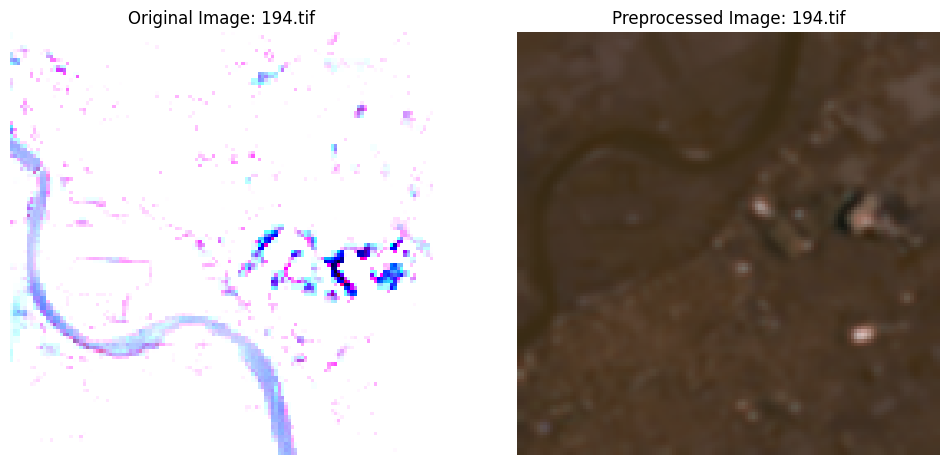

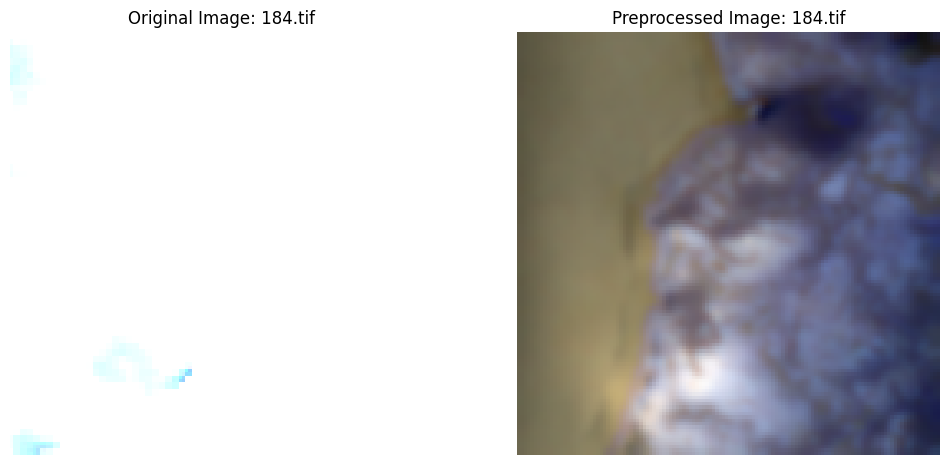

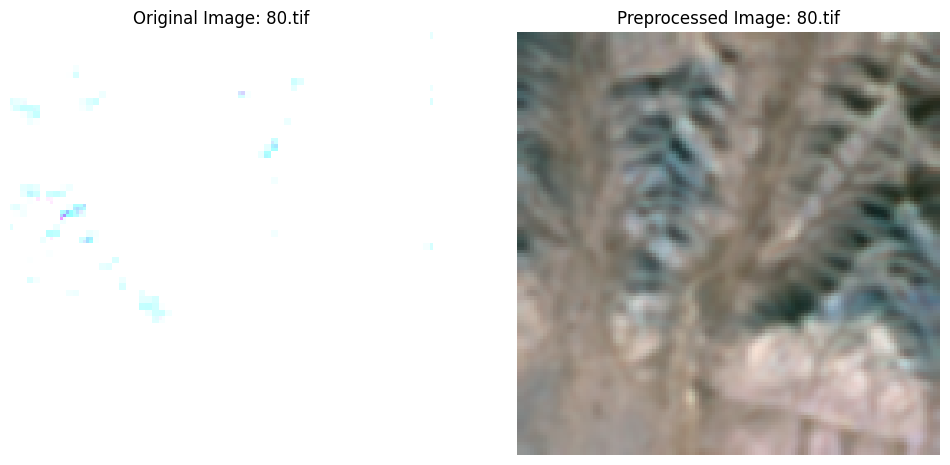

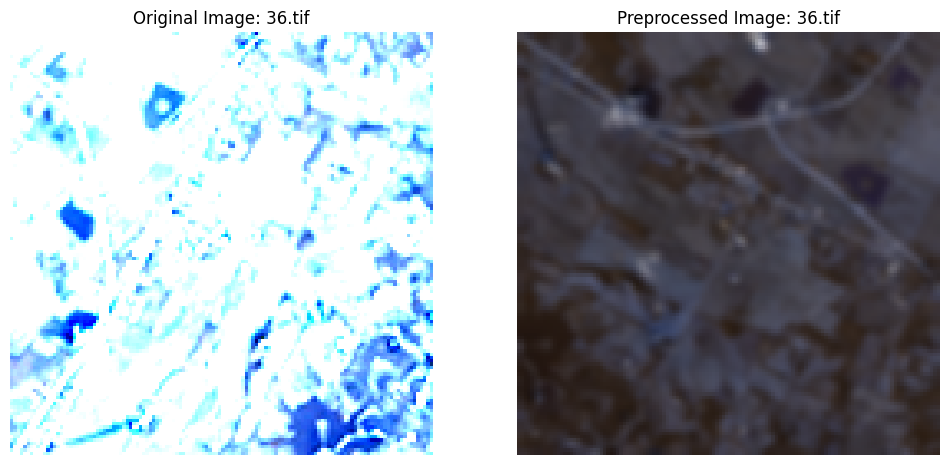

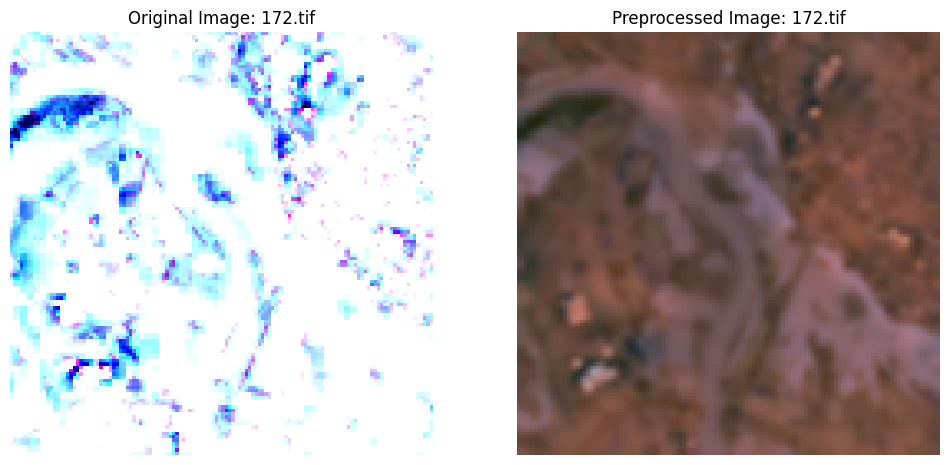

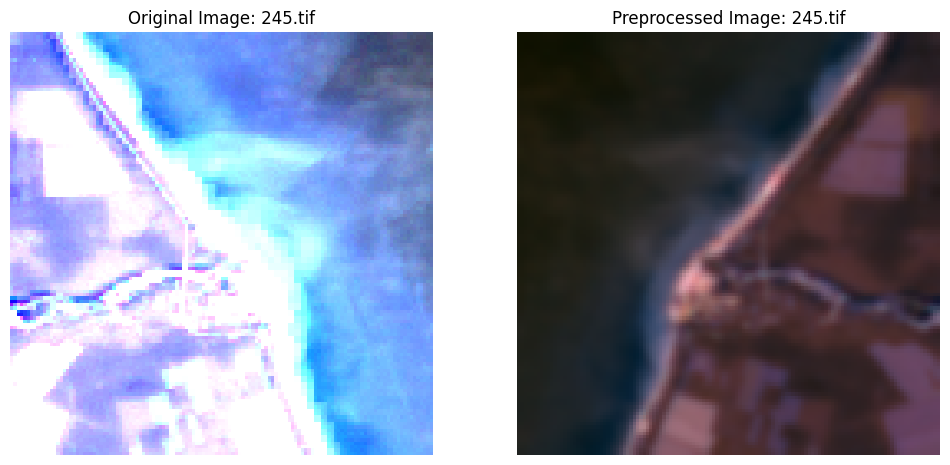

In [16]:

images_path = "/content/drive/My Drive/data/images"
max_images = 6  # Limit the number of images to display
count = 0

for filename in os.listdir(images_path):
    if filename.endswith(('.tif', '.tiff', '.geotiff')):
        image_path = os.path.join(images_path, filename)  # Construct full image path

        # Load and preprocess image
        image, metadata = load_multispectral_image(image_path)
        preprocessed_image = preprocess_image(image)

        # Show comparison
        visualize_comparison(image, preprocessed_image, filename)

        count += 1
        if count >= max_images:  # Stop after displaying max_images
            break


In [17]:
def visualize_bands(image, title=""):
    """Displays each band of the multispectral image separately."""
    num_bands = image.shape[2]  # Assuming the image has (height, width, bands)
    fig, axes = plt.subplots(1, num_bands, figsize=(num_bands * 4, 4))

    if num_bands == 1:
        axes = [axes]

    for i in range(num_bands):
        ax = axes[i]
        band_image = image[:, :, i]
        im = ax.imshow(band_image, cmap="gray")
        ax.set_title(f"Band {i+1}")
        ax.axis("off")
        plt.colorbar(im, ax=ax)

    # Add the title for the whole plot
    plt.suptitle(title)
    plt.show()


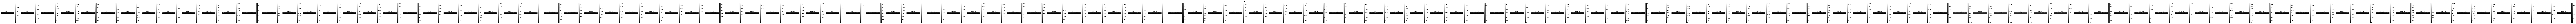

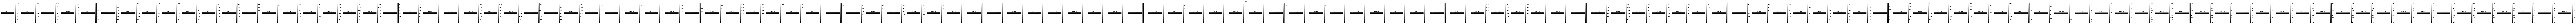

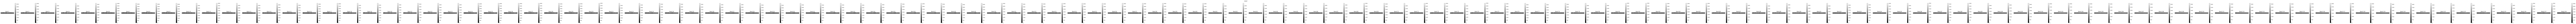

In [18]:
images_path = "/content/drive/My Drive/data/images"
max_images = 3 # Limit the number of images displayed
count = 0

for filename in os.listdir(images_path):
    if filename.endswith(('.tif', '.tiff', '.geotiff')):
        image_path = os.path.join(images_path, filename)  # Construct full image path

        # Load image
        image, metadata = load_multispectral_image(image_path)

        # Show band-wise visualization
        visualize_bands(image, filename)

        count += 1
        if count >= max_images:  # Stop after displaying max_images
            break


# Modeling

Prepare the data

In [23]:
import os
import cv2
import numpy as np

images_path = "/content/drive/My Drive/data/images"
label_dir = "/content/drive/My Drive/data/labels"

images = []  # List to store images
labels = []  # List to store labels (masks)

# Get a list of label filenames (without extensions)
label_files = {os.path.splitext(f)[0]: f for f in os.listdir(label_dir) if f.endswith(".png")}

# Loop over image files
for image_file in os.listdir(images_path):
    if image_file.endswith(('.tif', '.tiff', '.geotiff')):
        image_path = os.path.join(images_path, image_file)

        # Load the image (assuming a function to load multispectral images)
        image, metadata = load_multispectral_image(image_path)
        normalized_image = normalize_image(image)

        # Generate expected label filename (without _label)
        image_name = os.path.splitext(image_file)[0]  # Remove .tif or .tiff extension
        label_file = label_files.get(image_name)  # Get corresponding .png label

        if label_file is None:
            print(f"Label file not found for image: {image_file}")
            continue  # Skip if label not found

        label_path = os.path.join(label_dir, label_file)

        # Load the label
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        # Check if label is loaded properly
        if label is None:
            print(f"Failed to load label for {image_file}")
        else:
            print(f"Successfully loaded label for {image_file}")

            # Resize label to match the image size
            label_resized = cv2.resize(label, (128, 128))  # Adjust size as needed
            label_resized = np.expand_dims(label_resized, axis=-1)  # Add channel dimension

            # Append to the lists
            labels.append(label_resized)
            images.append(normalized_image)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Successfully loaded label for 194.tif
Successfully loaded label for 184.tif
Successfully loaded label for 80.tif
Successfully loaded label for 36.tif
Successfully loaded label for 172.tif
Successfully loaded label for 245.tif
Successfully loaded label for 24.tif
Successfully loaded label for 66.tif
Successfully loaded label for 1.tif
Successfully loaded label for 193.tif
Successfully loaded label for 70.tif
Successfully loaded label for 136.tif
Successfully loaded label for 271.tif
Successfully loaded label for 0.tif
Successfully loaded label for 3.tif
Successfully loaded label for 25.tif
Successfully loaded label for 35.tif
Successfully loaded label for 283.tif
Successfully loaded label for 77.tif
Successfully loaded label for 63.tif
Successfully loaded label for 209.tif
Successfully loaded label for 94.tif
Successfully loaded label for 257.tif
Successfully loaded label for 57.tif
Successfully loaded label for 277.tif
Successfully loaded label for 227.tif
Successfully loaded label for

In [24]:
print("Number of images:", len(images))
print("Number of labels:", len(labels))


Number of images: 306
Number of labels: 306


In [25]:
# Ensure you iterate over image files in the images directory
for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)  # Full path to image file

    # Ensure it's an image file (check extensions)
    if image_file.endswith(('.tif', '.tiff', '.geotiff')):
        print(f"Loading image: {image_path}")  # Check if path is correct
        image, metadata = load_multispectral_image(image_path)


Loading image: /content/drive/My Drive/data/images/194.tif
Loading image: /content/drive/My Drive/data/images/184.tif
Loading image: /content/drive/My Drive/data/images/80.tif
Loading image: /content/drive/My Drive/data/images/36.tif
Loading image: /content/drive/My Drive/data/images/172.tif
Loading image: /content/drive/My Drive/data/images/245.tif
Loading image: /content/drive/My Drive/data/images/24.tif
Loading image: /content/drive/My Drive/data/images/66.tif
Loading image: /content/drive/My Drive/data/images/1.tif
Loading image: /content/drive/My Drive/data/images/193.tif
Loading image: /content/drive/My Drive/data/images/70.tif
Loading image: /content/drive/My Drive/data/images/136.tif
Loading image: /content/drive/My Drive/data/images/271.tif
Loading image: /content/drive/My Drive/data/images/0.tif
Loading image: /content/drive/My Drive/data/images/3.tif
Loading image: /content/drive/My Drive/data/images/25.tif
Loading image: /content/drive/My Drive/data/images/35.tif
Loading im

In [62]:
# Example to check if image loading works
images_path='/content/drive/My Drive/data/images'
image, metadata = load_multispectral_image(image_path)
print(f"Image loaded with shape: {image.shape}")  # Should print the shape of the image


Image loaded with shape: (12, 128, 128)


In [63]:
print(f"Images shape: {images.shape}")  # Should be (306, height, width, channels)
print(f"Labels shape: {labels.shape}")  # Should be (306, height, width, 1)


Images shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128, 1)


In [64]:
if labels.shape[-1] == 1:  # Check if last dimension is 1
    labels = labels.squeeze(-1)

print("Updated Labels shape:", labels.shape)  # Should be (306, 128, 128)


Updated Labels shape: (306, 128, 128)


In [67]:
print("Final Images shape:", images.shape)  # Expected: (306, 12, 128, 128)
print("Final Labels shape:", labels.shape)  # Expected: (306, 128, 128)
from sklearn.model_selection import train_test_split
# Now do the train-test split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")


Final Images shape: (306, 128, 128, 12)
Final Labels shape: (306, 128, 128)
Training set size: (244, 128, 128, 12), (244, 128, 128)
Validation set size: (62, 128, 128, 12), (62, 128, 128)


In [68]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the U-Net Model
def unet_model(input_size=(128, 128, 12)):  # Updated input size for 12 channels
    inputs = layers.Input(input_size)

    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Binary segmentation

    # Model Compilation
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = unet_model()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 128, 128, 64)   │          6,976 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ conv2d_60[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 256)    │              0 │ conv2d_62[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 8, 8, 512)      │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_12       │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_66[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12       

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Expand labels dimensions to (306, 128, 128, 1) if needed
labels = np.expand_dims(labels, axis=-1)  # Adding channel dimension (to make it 4D)
print("Updated Labels shape:", labels.shape)


Updated Labels shape: (306, 128, 128, 1)


In [74]:
# Correct transposition to get the shape (306, 128, 128, 12)
images = np.transpose(images, (0, 2, 3, 1))  # Move the channel dimension to the last position
print("Updated Images shape:", images.shape)  # Expected (306, 128, 128, 12)




Updated Images shape: (306, 128, 128, 12)


In [91]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # You can adjust this
    batch_size=16,  # Adjust based on GPU memory
    verbose=1
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.9577 - loss: 0.1017 - val_accuracy: 0.9429 - val_loss: 0.1460
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9522 - loss: 0.1132 - val_accuracy: 0.9397 - val_loss: 0.1575
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9462 - loss: 0.1245 - val_accuracy: 0.9426 - val_loss: 0.1420
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.9518 - loss: 0.1146 - val_accuracy: 0.9438 - val_loss: 0.1437
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9535 - loss: 0.1106 - val_accuracy: 0.9426 - val_loss: 0.1476
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.9555 - loss: 0.1063 - val_accuracy: 0.9432 - val_loss: 0.1516
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.9548 - loss: 0.1086 - val_accuracy: 0.9468 - val_loss: 0.1667
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.9602 - loss: 0.0978 - val_accu

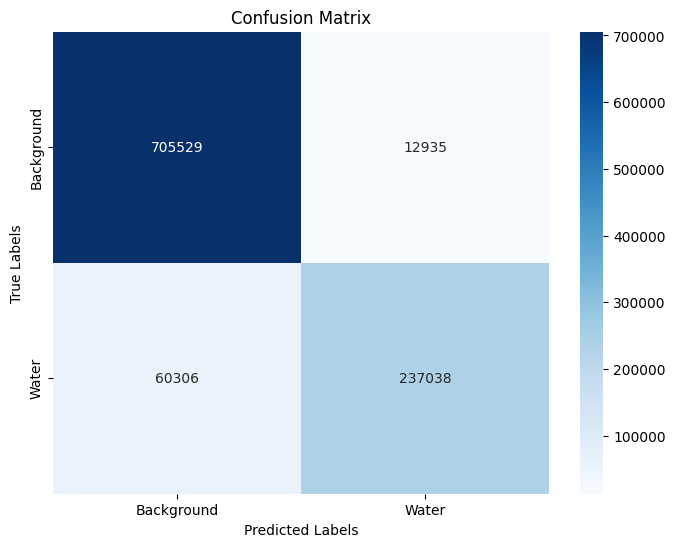

Precision: 0.9483
Recall: 0.7972
F1 Score: 0.8662
IoU: 0.7640


In [92]:
# Squeeze the predicted mask to remove the extra dimension
y_pred_binary = np.squeeze(y_pred_binary)

# Now both y_pred_binary and y_val should have the shape (62, 128, 128)
# Flatten the arrays to 1D for evaluation
y_true_flat = y_val.flatten()
y_pred_flat = y_pred_binary.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Water'], yticklabels=['Background', 'Water'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision, Recall, F1 score
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

# Calculate Intersection over Union (IoU) for water class
intersection = np.sum(np.logical_and(y_pred_binary, y_val))  # True positive pixels
union = np.sum(np.logical_or(y_pred_binary, y_val))         # Total pixels in either prediction or true label
iou = intersection / union

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")


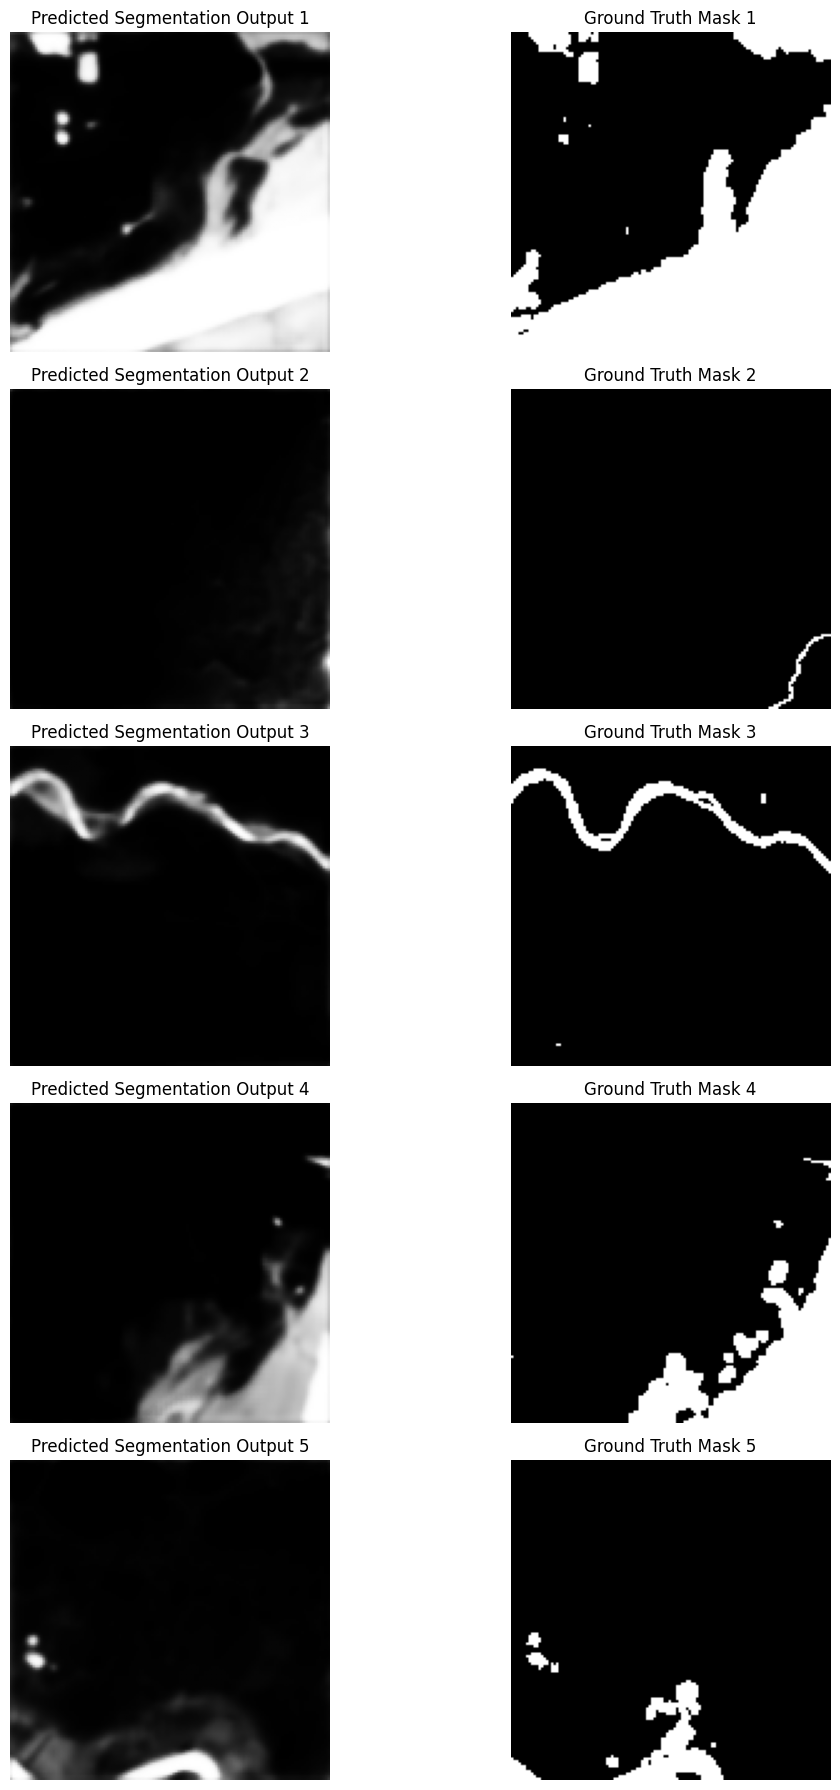

In [93]:
# Assuming y_pred has shape (batch_size, 128, 128, 12) and y_val has shape (batch_size, 128, 128)
# Choose the relevant channel (e.g., for water, we assume it's channel 0 for predictions)
# For visualization, you can display the first 3 predictions with their corresponding ground truths

fig, axes = plt.subplots(5, 2, figsize=(12, 18))  # 3 rows, 2 columns for 3 pairs of images

# Loop over 5 samples
for i in range(5):
    # Select the relevant segmentation output (e.g., water class: channel 0)
    segmentation_output = y_pred[i, :, :, 0]  # Example: select first channel for water class
    ground_truth = y_val[i, :, :]  # Ground truth mask (single channel)

    # Plot the segmentation output (e.g., water class)
    axes[i, 0].imshow(segmentation_output, cmap='gray')  # Use grayscale colormap for binary masks
    axes[i, 0].set_title(f"Predicted Segmentation Output {i+1}")
    axes[i, 0].axis('off')  # Turn off axis

    # Plot the corresponding ground truth mask
    axes[i, 1].imshow(ground_truth, cmap='gray')  # Grayscale colormap for binary mask
    axes[i, 1].set_title(f"Ground Truth Mask {i+1}")
    axes[i, 1].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


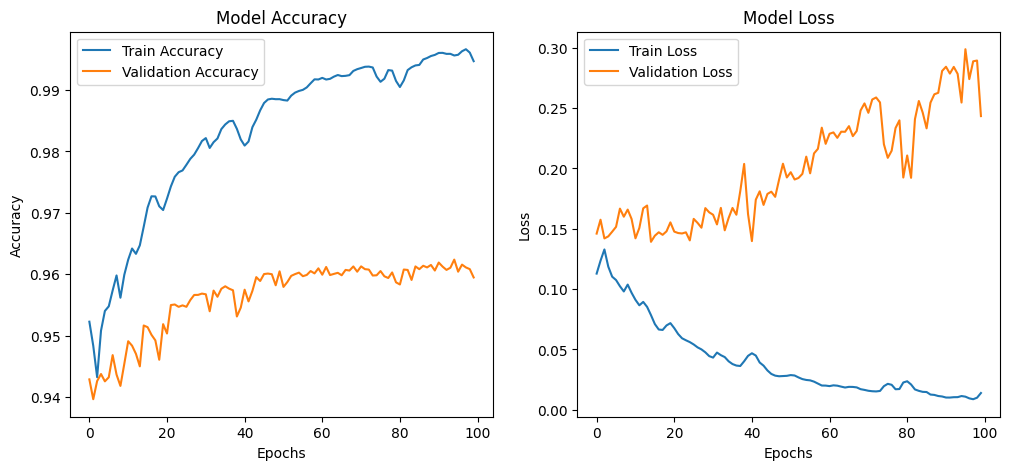

In [94]:
import matplotlib.pyplot as plt

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()


plot_history(history)
